In [ ]:
%pip install tensorflow==2.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 621.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempt

In [ ]:
pip install deepxde


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

###**Defining the Partial Differential Equation**

---


In [ ]:
# Define the PDE
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    d2u_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t + du_x - (1 / 1000) * d2u_xx - 0.5


###**Defining the Initial and Boundary Conditions**

In [ ]:
def initial_condition(x):
    return np.where(
        (x[:, 0] >= 0.25) & (x[:, 0] < 0.375),
        8 * (x[:, 0] - 0.25),
        np.where(
            (x[:, 0] >= 0.375) & (x[:, 0] <= 0.5),
            8 * (0.5 - x[:, 0]),
            0.0
        )
    ).reshape(-1, 1)

# Combined boundary condition function for u(0,t) = 0 and u(1,t) = 0
def boundary_conditions(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 0) or np.isclose(x[0], 1))

### **2. Creating & Training the Model**

Compiling model...
Building feed-forward neural network...
'build' took 0.055186 s

'compile' took 0.584660 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.93e-01, 9.39e-04, 7.98e-02]    [5.93e-01, 9.39e-04, 7.98e-02]    []  
1000      [2.19e-04, 9.94e-05, 3.08e-03]    [2.19e-04, 9.94e-05, 3.08e-03]    []  
2000      [1.24e-04, 4.43e-05, 6.42e-04]    [1.24e-04, 4.43e-05, 6.42e-04]    []  
3000      [4.55e-05, 1.86e-05, 4.76e-04]    [4.55e-05, 1.86e-05, 4.76e-04]    []  
4000      [1.92e-05, 2.03e-05, 4.12e-04]    [1.92e-05, 2.03e-05, 4.12e-04]    []  
5000      [9.69e-06, 2.15e-05, 3.82e-04]    [9.69e-06, 2.15e-05, 3.82e-04]    []  
6000      [7.42e-06, 2.21e-05, 3.66e-04]    [7.42e-06, 2.21e-05, 3.66e-04]    []  
7000      [1.10e-05, 4.76e-05, 4.76e-04]    [1.10e-05, 4.76e-05, 4.76e-04]    []  
8000      [9.61e-06, 2.25e-05, 3.52e-04]    [9.61e-06, 2.25e-05, 3.52e-04]    []  
9000      [1.01e-05, 2.26e-05, 3.

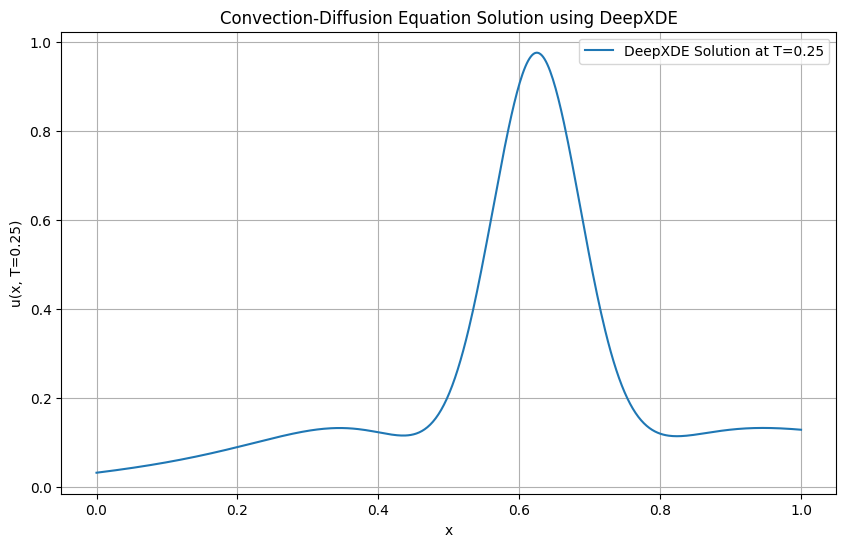

In [ ]:
# Define the domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 0.25)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary conditions with a single function
bc = dde.DirichletBC(geomtime, lambda x: 0, boundary_conditions)

# Combine the conditions
ic = dde.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)

# Define the data for the PINN
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=512, num_boundary=2, num_initial=512)

# Define the neural network model
net = dde.nn.FNN([2] + [75] * 3 + [1], "tanh", "Glorot uniform")

# Define the model
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)


x_values = np.linspace(0, 1, 512)
t_values = np.full_like(x_values, 0.25)
X = np.vstack((x_values, t_values)).T

# Predict the solution on this grid
u_pred = model.predict(X)

# Plot the solution at T=0.25
plt.figure(figsize=(10, 6))
plt.plot(x_values, u_pred, label="DeepXDE Solution at T=0.25")
plt.title("Convection-Diffusion Equation Solution using DeepXDE")
plt.xlabel("x")
plt.ylabel("u(x, T=0.25)")
plt.legend()
plt.grid(True)
plt.show()